In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Данные для тестов

In [3]:
def malanchev_dataset(inliers=2**10, outliers=2**5, seed=0):
    rng = np.random.default_rng(seed)
    x = np.concatenate([rng.uniform([0, 0], [0.5, 0.5], (inliers, 2)),
                        rng.normal([1, 1], 0.1, (outliers, 2)),
                        rng.normal([0, 1], 0.1, (outliers, 2)),
                        rng.normal([1, 0], 0.1, (outliers, 2))])
    return x

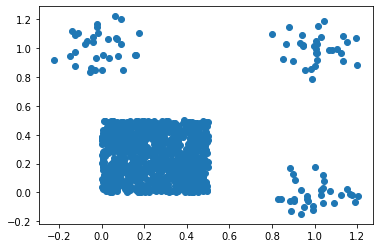

In [4]:
plt.scatter(*malanchev_dataset().T);

# Оценка средней длины пути в дереве

In [5]:
def _average_path_length(n):
    """
    Average path length formula.
    """
    return 2.0 * (np.log(n - 1.0) + np.euler_gamma) - 2.0 * (n - 1.0) / n


def average_path_length(n):
    """
    Average path length computation.
    Parameters
    ----------
    n
        Either array of tree depths to computer average path length of
        or one tree depth scalar.
    Returns
    -------
    Average path length.
    """
    if np.isscalar(n):
        if n <= 1:
            apl = 0
        elif n == 2:
            apl = 1
        else:
            apl = _average_path_length(n)
    else:
        n = np.asarray(n)
        apl = np.zeros_like(n)
        apl[n > 1] = _average_path_length(n[n > 1])
        apl[n == 2] = 1

    return apl

# Изоляционный лес

In [6]:
class IsolationForest:
    def __init__(self, trees=100, subsamples=256, depth=None, seed=0):
        self.subsamples = subsamples
        self.trees = trees
        self.depth = depth

        self.seedseq = np.random.SeedSequence(seed)
        self.rng = np.random.default_rng(seed)

        self.estimators = []
        self.n = 0

    def fit(self, data):
        n = data.shape[0]
        self.n = n
        self.subsamples = self.subsamples if n > self.subsamples else n

        self.depth = self.depth or int(np.ceil(np.log2(self.subsamples)))

        self.estimators = [None] * self.trees
        seeds = self.seedseq.spawn(self.trees)
        for i in range(self.trees):
            subs = self.rng.choice(n, self.subsamples)
            gen = IsolationForestGenerator(data[subs, :], self.depth, seeds[i])
            self.estimators[i] = gen.pine

        return self

    def mean_paths(self, data):
        means = np.zeros(data.shape[0])
        for ti in range(self.trees):
            path = self.estimators[ti].paths(data)
            means += path

        means /= self.trees
        return means

    def scores(self, data):
        means = self.mean_paths(data)
        return - 2 ** (-means / average_path_length(self.subsamples))


class Tree:
    def __init__(self, features, selectors, values):
        self.features = features
        self.len = selectors.shape[0]

        # Two complementary arrays.
        # Selectors select feature to branch on.
        self.selectors = selectors
        # Values either set the deciding feature value or set the closing path length
        self.values = values

    def _get_one_path(self, key):
        i = 1
        while 2 * i < self.selectors.shape[0]:
            f = self.selectors[i]
            if f < 0:
                break

            if key[f] <= self.values[i]:
                i = 2 * i
            else:
                i = 2 * i + 1

        return self.values[i]

    def paths(self, x):
        n = x.shape[0]
        paths = np.empty(n)
        for i in range(n):
            paths[i] = self._get_one_path(x[i, :])

        return paths


class IsolationForestGenerator:
    def __init__(self, sample, depth, seed=0):
        self.depth = depth
        self.features = sample.shape[1]
        self.length = 1 << (depth + 1)
        self.rng = np.random.default_rng(seed)
        self.selectors = np.full(self.length, -1, dtype=np.int32)
        self.values = np.full(self.length, 0, dtype=np.float64)

        self._populate(1, sample)

        self.pine = Tree(self.features, self.selectors, self.values)

    def _populate(self, i, sample):

        if sample.shape[0] == 1:
            self.values[i] = np.floor(np.log2(i))
            return

        if self.length <= 2 * i:
            self.values[i] = np.floor(np.log2(i)) + \
                             average_path_length(sample.shape[0])

            return

        selector = self.rng.integers(self.features)
        self.selectors[i] = selector

        minval = np.min(sample[:, selector])
        maxval = np.max(sample[:, selector])
        if minval == maxval:
            self.selectors[i] = -1
            self.values[i] = np.floor(np.log2(i)) + \
                average_path_length(sample.shape[0])

            return

        value = self.rng.uniform(minval, maxval)
        self.values[i] = value

        self._populate(2 * i, sample[sample[:, selector] <= value])
        self._populate(2 * i + 1, sample[sample[:, selector] > value])

# Пример

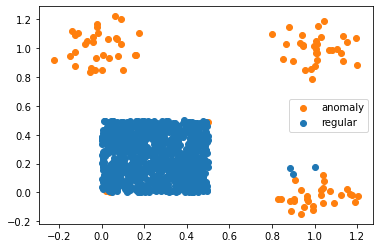

In [7]:
data = malanchev_dataset()
isoforest = IsolationForest(trees=100, subsamples=16, depth=4)
isoforest.fit(data)
scores = isoforest.scores(data)
sorting = np.argsort(scores)

plt.scatter(*data[sorting[:96]].T, color='C1', label='anomaly')
plt.scatter(*data[sorting[96:]].T, color='C0', label='regular')
plt.legend()
pass

# Тесты

In [8]:
data = malanchev_dataset(inliers=2**13)

In [9]:
%%time
isoforest = IsolationForest(trees=200, subsamples=1024, depth=10)
isoforest.fit(data)
pass

CPU times: user 2.35 s, sys: 1.22 ms, total: 2.35 s
Wall time: 2.38 s


In [10]:
%%time
scores = isoforest.scores(data)

CPU times: user 46.9 s, sys: 147 ms, total: 47 s
Wall time: 47.9 s


In [13]:
# Если посчитать для 10e6 точек (в часах):
48 / 2**13 * 10e6 / 60.0 / 60.0

16.276041666666668